# Easy Money - Modelo de propensión a compra

Vamos a desarrollar un modelo capaz de **predecir si un cliente es propenso a contratar la tarjeta de crédito de Easy Money, teniendo en cuenta sus características**.

## Importación de librerías

In [1]:
# Importamos las librerias necesarias.
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, OrdinalEncoder
from sklearn import model_selection 
from sklearn import metrics
from sklearn.model_selection import train_test_split

## Importación de datos

De las tablas que tenemos disponibles en BBDD, las que serán de utilidad para este modelo son customer_sociodemographics, custommer_products y customer_commercial_activity.
<p>Guardamos los datos de las tablas en dataframes distintos que limpiaremos, y posteriormente uniremos en un único dataframe 


In [2]:
# Obtener el directorio de trabajo actual
current_dir = os.getcwd()

# Ir a la carpeta anterior del directorio actual porque ahí se encuentra la carpeta 'data' donde están todos los ficheros .csv
parent_dir = os.path.dirname(current_dir)

DATA_PATH = os.path.join(parent_dir, 'data/') # Ruta donde están los ficheros .csv

FILE_NAME1 = 'customer_sociodemographics.csv'
FILE1 = os.path.join(DATA_PATH, FILE_NAME1)

FILE_NAME2 = 'customer_commercial_activity.csv'
FILE2 = os.path.join(DATA_PATH, FILE_NAME2)

FILE_NAME4 = 'customer_products.csv'
FILE4 = os.path.join(DATA_PATH, FILE_NAME4)

print('current path:', current_dir)
print('parent path:', parent_dir)
print('data path:', DATA_PATH)
print('file 1:', FILE1)
print('file 2:', FILE2)
print('file 4:', FILE4)
print('data path:', DATA_PATH)

current path: c:\Users\odoto\Documents\Nuclio\TFM-EasyMoney\clustering
parent path: c:\Users\odoto\Documents\Nuclio\TFM-EasyMoney
data path: c:\Users\odoto\Documents\Nuclio\TFM-EasyMoney\data/
file 1: c:\Users\odoto\Documents\Nuclio\TFM-EasyMoney\data/customer_sociodemographics.csv
file 2: c:\Users\odoto\Documents\Nuclio\TFM-EasyMoney\data/customer_commercial_activity.csv
file 4: c:\Users\odoto\Documents\Nuclio\TFM-EasyMoney\data/customer_products.csv
data path: c:\Users\odoto\Documents\Nuclio\TFM-EasyMoney\data/


In [3]:
df_cs = pd.read_csv(FILE1, index_col=0)
df_cca = pd.read_csv(FILE2, index_col=0)
df_customer_products = pd.read_csv(FILE4, index_col=0)

## 1: Data Understanding

### 1.1: Análisis Univariante de datos de las distintos datasets que vamos a usar

#### 1.1.1 Analizamos la tabla customer_sociodemographics

In [4]:
# Datos generales 

df_cs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5962924 entries, 0 to 13647308
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   pk_cid        int64  
 1   pk_partition  object 
 2   country_id    object 
 3   region_code   float64
 4   gender        object 
 5   age           int64  
 6   deceased      object 
 7   salary        float64
dtypes: float64(2), int64(2), object(4)
memory usage: 409.4+ MB


In [5]:
# Visualización de los datos
df_cs.head()

,pk_cid,pk_partition,country_id,region_code,gender,age,deceased,salary
0,1375586,2018-01,ES,29.0,H,35,N,87218.10
1,1050611,2018-01,ES,13.0,V,23,N,35548.74
2,1050612,2018-01,ES,13.0,V,23,N,122179.11
3,1050613,2018-01,ES,50.0,H,22,N,119775.54
4,1050614,2018-01,ES,50.0,V,23,N,NaN


In [6]:
# Recuento de nulos 

df_cs.isna().sum()

pk_cid                0
pk_partition          0
country_id            0
region_code        2264
gender               25
age                   0
deceased              0
salary          1541104
dtype: int64

De entrada, analizamos la columna "deceased" para eliminar los clientes fallecidos y quedarnos con aquellos que actualmente son reales

In [7]:
df_cs['deceased'].value_counts()

deceased
N    5961849
S       1075
Name: count, dtype: int64

In [8]:
df_cs = df_cs[(df_cs['deceased']  == 'N')]
df_cs['deceased'].value_counts()

deceased
N    5961849
Name: count, dtype: int64

Ahora que nos hemos quedado solamente con los clientes no fallecidos, esta columna no es de mucha utilidad ya que siempre tiene el mismo valor. La podemos eliminar.

In [9]:
del(df_cs['deceased'])

Analizamos también la columna country_id para ver si vale la pena quedarnos con todos los países de la BBDD 

In [10]:
df_cs['country_id'].value_counts()

country_id
ES    5959602
GB        441
FR        225
DE        199
US        195
CH        189
BR         87
BE         81
VE         79
IE         68
MX         58
AT         51
AR         51
PL         49
IT         45
MA         34
CL         30
CN         28
CA         22
LU         17
ET         17
QA         17
CI         17
SA         17
CM         17
SN         17
MR         17
NO         17
RU         17
CO         17
GA         17
GT         17
DO         17
SE         16
DJ         11
PT         11
JM         11
RO          9
HU          8
DZ          7
PE          4
Name: count, dtype: int64

Vemos que los valores de los países distintos a ES son muy pequeños y no aportarán demasiado valor a nuestro modelo. Nos quedamos solamente con los registros que son country_id = ES

In [11]:
df_cs = df_cs[(df_cs['country_id']  == 'ES')]
df_cs['country_id'].value_counts()

country_id
ES    5959602
Name: count, dtype: int64

Ahora que nos hemos quedado solamente con los clientes de ES, esta columna no es de mucha utilidad ya que siempre tiene el mismo valor. La podemos eliminar.

In [12]:
del(df_cs['country_id'])

Según el diccionario de las tablas, region_code es el código de provincia. Este dato sí puede ser relevante, pero vemos que tiene nulos. Como estamos ante un modelo de clasificación binaria, podemos rellenar los nulos con un valor como -1, para que se sean agrupados en un bloque propio.

In [13]:
df_cs['region_code'].fillna(-1, inplace=True)

C:\Users\odoto\AppData\Local\Temp\ipykernel_29660\1372854579.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cs['region_code'].fillna(-1, inplace=True)


La columna gender también tenía nulos, pero son muy pocos en relación al total del dataset. Analizamos cuántos nulos quedan después de los cambios ya realizados y elimnamos estas filas por ser muy pocas

In [14]:
df_cs['gender'].isna().sum()

25

In [15]:
df_cs = df_cs.dropna(subset =['gender'])

Analizamos la columna salary 

In [16]:
df_cs['salary'].value_counts()

salary
451931.22    709
288997.44    546
135522.15    466
128318.52    458
104563.80    436
            ... 
127111.23      1
100303.05      1
125135.46      1
188185.68      1
167276.64      1
Name: count, Length: 257626, dtype: int64

In [17]:
df_cs['salary'].describe()

count    4.420911e+06
mean     1.155810e+05
std      2.000189e+05
min      1.202730e+03
25%      6.141354e+04
50%      8.843742e+04
75%      1.313081e+05
max      2.889440e+07
Name: salary, dtype: float64

Vemos que todos los valores son positivos, que la diferencia entre el salario mayor y el salario menor es muy grande, y que la media por tanto es muy elevada también. Igualmente, según el diccionario de la BBDD, se trata del salario de la unidad familiar y consideramos que este valor es importante a la hora de determinar la contratación. Al haber muchos nulos, y al ser el modelo de clasificación binaria, vamos a asignar a los nulos el valor -1

In [18]:
df_cs['salary'].fillna(-1, inplace=True)

C:\Users\odoto\AppData\Local\Temp\ipykernel_29660\3059662271.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cs['salary'].fillna(-1, inplace=True)


Transformamos la columna region_code de float a int

In [19]:
df_cs["region_code"] = df_cs["region_code"].astype(int)

Transformamos la columna pk_partition a fecha

In [20]:
df_cs["pk_partition"] = pd.to_datetime(df_cs["pk_partition"])


Finalmente, la tabla de customer_sociodemographics quedará así:

In [21]:
df_cs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5959577 entries, 0 to 13647308
Data columns (total 6 columns):
 #   Column        Dtype         
---  ------        -----         
 0   pk_cid        int64         
 1   pk_partition  datetime64[ns]
 2   region_code   int32         
 3   gender        object        
 4   age           int64         
 5   salary        float64       
dtypes: datetime64[ns](1), float64(1), int32(1), int64(2), object(1)
memory usage: 295.5+ MB


#### 1.1.2 Analizamos la tabla customer_commercial_activity

In [22]:
# Datos generales 

df_cca.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5962924 entries, 0 to 13647308
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   pk_cid           int64  
 1   pk_partition     object 
 2   entry_date       object 
 3   entry_channel    object 
 4   active_customer  float64
 5   segment          object 
dtypes: float64(1), int64(1), object(4)
memory usage: 318.5+ MB


In [23]:
# Visualización de los datos
df_cca.head()

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment
0,1375586,2018-01,2018-01,KHL,1.0,02 - PARTICULARES
1,1050611,2018-01,2015-08,KHE,0.0,03 - UNIVERSITARIO
2,1050612,2018-01,2015-08,KHE,0.0,03 - UNIVERSITARIO
3,1050613,2018-01,2015-08,KHD,0.0,03 - UNIVERSITARIO
4,1050614,2018-01,2015-08,KHE,1.0,03 - UNIVERSITARIO


In [24]:
# Recuento de nulos 

df_cca.isna().sum()

pk_cid                  0
pk_partition            0
entry_date              0
entry_channel      133033
active_customer         0
segment            133944
dtype: int64

In [25]:
pd.set_option('display.max_rows', 100)

In [26]:
df_cca['entry_channel'].value_counts(normalize = True)*100

entry_channel
KHE    53.413469
KFC    15.276786
KHQ    10.125061
KAT     7.137080
KHK     3.948564
KHM     3.029062
KHN     1.859966
KFA     1.355428
KHD     1.301894
RED     1.039488
KHL     0.715897
KHF     0.354329
KHO     0.141461
KAZ     0.096657
KHC     0.089899
KBG     0.028508
KEH     0.012487
KHP     0.011853
007     0.010515
013     0.006810
KAG     0.005746
KAS     0.005232
KBZ     0.003396
KAA     0.003311
KAR     0.002693
KAY     0.002556
KAF     0.002110
KAB     0.001630
KFD     0.001561
KCC     0.001527
KAW     0.001115
KAQ     0.000892
KDH     0.000875
KAE     0.000823
KCH     0.000823
KCB     0.000806
KAD     0.000772
KAM     0.000738
KAH     0.000686
KAK     0.000583
KAJ     0.000566
KDT     0.000395
KFF     0.000377
KBO     0.000360
KEY     0.000343
KGC     0.000292
004     0.000292
KFS     0.000292
KCL     0.000292
KBE     0.000292
KBH     0.000292
KFK     0.000292
KGN     0.000292
KCI     0.000292
KGX     0.000292
KDR     0.000274
KFL     0.000223
KBW     0.000206


Vemos muchos valores de Entry Channel que son muy pocos en comparación con los valores mayoritarios. Elegimos los canales de entrada que tengan una proporción mayor al 1% y agrupamos el resto en Others

In [27]:
value_counts = (df_cca['entry_channel'].value_counts(normalize = True, dropna=True)*100)
df_cca['entry_channel'] = df_cca['entry_channel'].apply(lambda x: x if pd.isna(x) or value_counts.get(x, 0) >= 1 else 'Others')

In [28]:
df_cca['entry_channel'].value_counts(normalize = True)*100

entry_channel
KHE       53.413469
KFC       15.276786
KHQ       10.125061
KAT        7.137080
KHK        3.948564
KHM        3.029062
KHN        1.859966
Others     1.513202
KFA        1.355428
KHD        1.301894
RED        1.039488
Name: proportion, dtype: float64

Analizamos la columna segment para ver los valores únicos, sabiendo que también tiene nulos

In [29]:
df_cca['segment'].value_counts()

segment
03 - UNIVERSITARIO    3900166
02 - PARTICULARES     1830875
01 - TOP                97939
Name: count, dtype: int64

Rellenamos NaN de channel y segment con un valor identificativo como 'Not defined'

In [30]:
df_cca["entry_channel"].fillna('Not defined', inplace=True)
df_cca["segment"].fillna('Not defined', inplace=True)

C:\Users\odoto\AppData\Local\Temp\ipykernel_29660\2969524961.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cca["entry_channel"].fillna('Not defined', inplace=True)
C:\Users\odoto\AppData\Local\Temp\ipykernel_29660\2969524961.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a cop

In [31]:
df_cca.isna().sum()

pk_cid             0
pk_partition       0
entry_date         0
entry_channel      0
active_customer    0
segment            0
dtype: int64

In [32]:
df_cca['active_customer'].value_counts()

active_customer
0.0    3557573
1.0    2405351
Name: count, dtype: int64

Transformarmos active_customer de float a int

In [33]:
df_cca["active_customer"] = df_cca["active_customer"].astype(int)

Transformamos las columna pk_partition y entry_date a fecha

In [34]:
df_cca["pk_partition"] = pd.to_datetime(df_cca["pk_partition"])
df_cca["entry_date"] = pd.to_datetime(df_cca["entry_date"])

Finalmente, la tabla de customer_commercial_activity quedará así:

In [35]:
df_cca.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5962924 entries, 0 to 13647308
Data columns (total 6 columns):
 #   Column           Dtype         
---  ------           -----         
 0   pk_cid           int64         
 1   pk_partition     datetime64[ns]
 2   entry_date       datetime64[ns]
 3   entry_channel    object        
 4   active_customer  int32         
 5   segment          object        
dtypes: datetime64[ns](2), int32(1), int64(1), object(2)
memory usage: 295.7+ MB


## 1.3 Analizamos el dataset de customer product

In [36]:
df_customer_products.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5962924 entries, 0 to 13647308
Data columns (total 17 columns):
 #   Column              Dtype  
---  ------              -----  
 0   pk_cid              int64  
 1   pk_partition        object 
 2   short_term_deposit  int64  
 3   loans               int64  
 4   mortgage            int64  
 5   funds               int64  
 6   securities          int64  
 7   long_term_deposit   int64  
 8   em_account_pp       int64  
 9   credit_card         int64  
 10  payroll             float64
 11  pension_plan        float64
 12  payroll_account     int64  
 13  emc_account         int64  
 14  debit_card          int64  
 15  em_account_p        int64  
 16  em_acount           int64  
dtypes: float64(2), int64(14), object(1)
memory usage: 818.9+ MB


In [37]:
df_customer_products["pk_partition"] = pd.to_datetime(df_customer_products["pk_partition"] )

In [38]:
df_customer_products.isnull().sum()

pk_cid                 0
pk_partition           0
short_term_deposit     0
loans                  0
mortgage               0
funds                  0
securities             0
long_term_deposit      0
em_account_pp          0
credit_card            0
payroll               61
pension_plan          61
payroll_account        0
emc_account            0
debit_card             0
em_account_p           0
em_acount              0
dtype: int64

In [39]:
df_customer_products["payroll"]=df_customer_products["payroll"].fillna(0)
df_customer_products[ 'pension_plan']=df_customer_products[ 'pension_plan'].fillna(0)

In [40]:
df_customer_products.isnull().sum()

pk_cid                0
pk_partition          0
short_term_deposit    0
loans                 0
mortgage              0
funds                 0
securities            0
long_term_deposit     0
em_account_pp         0
credit_card           0
payroll               0
pension_plan          0
payroll_account       0
emc_account           0
debit_card            0
em_account_p          0
em_acount             0
dtype: int64

Hemos limpiado los datasets por separado y ahora los juntaremos con un merge para poder generar el dataframe de nuestro modelo.

## 2: Construcción del dataset para el modelo

Vamos a hacer un inner merge de todos los datasets, ya que nos interesa agrupar toda la información analizada en un único dataframe, que contenga toda la información por el id de cliente y la fecha de partición.

In [41]:
df_merged = pd.merge(
    left = df_cca, 
    right = df_cs,
    on = ('pk_cid', 'pk_partition'),
    how = 'inner')

In [42]:
df_merged.head()

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,region_code,gender,age,salary
0,1375586,2018-01-01,2018-01-01,Others,1,02 - PARTICULARES,29,H,35,87218.10
1,1050611,2018-01-01,2015-08-01,KHE,0,03 - UNIVERSITARIO,13,V,23,35548.74
2,1050612,2018-01-01,2015-08-01,KHE,0,03 - UNIVERSITARIO,13,V,23,122179.11
3,1050613,2018-01-01,2015-08-01,KHD,0,03 - UNIVERSITARIO,50,H,22,119775.54
4,1050614,2018-01-01,2015-08-01,KHE,1,03 - UNIVERSITARIO,50,V,23,-1.00


In [43]:
df_merged2 = pd.merge(
    left = df_merged, 
    right = df_customer_products,
    on = ('pk_cid', 'pk_partition'),
    how = 'inner')

In [44]:
pd.set_option('display.max_rows', 1000)

### Limpiamos todas las particiones menos la última 5-2019

Para limpiar las particiones que no nos interesan, guardamos un dataframe llamado df_merged2 con los datos del dataframe mergeado que tengan la partición que queremos = 2019-05.

In [45]:
df_merged2=df_merged2.loc[df_merged2['pk_partition'] =='2019-05']

In [46]:
df_merged2

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,region_code,gender,age,salary,...,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
5516831,657826,2019-05-01,2015-05-01,Others,1,02 - PARTICULARES,25,H,44,54493.38,...,0,0,0,0.0,0.0,0,0,0,0,1
5516832,657817,2019-05-01,2019-05-01,Not defined,0,Not defined,8,V,32,-1.00,...,0,0,0,0.0,0.0,0,0,0,0,0
5516833,657986,2019-05-01,2016-02-01,Others,1,02 - PARTICULARES,41,H,39,100993.17,...,0,0,1,1.0,1.0,1,1,1,0,0
5516834,657905,2019-05-01,2017-02-01,KAT,1,01 - TOP,28,H,85,154059.09,...,1,0,0,0.0,0.0,0,0,0,0,1
5516835,657336,2019-05-01,2019-03-01,KAT,1,02 - PARTICULARES,28,V,38,-1.00,...,0,0,0,0.0,0.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5959572,1166765,2019-05-01,2016-08-01,KHE,0,03 - UNIVERSITARIO,50,V,22,43912.17,...,0,0,0,0.0,0.0,0,0,0,0,1
5959573,1166764,2019-05-01,2016-08-01,KHE,0,03 - UNIVERSITARIO,26,V,23,23334.99,...,0,0,0,0.0,0.0,0,0,0,0,1
5959574,1166763,2019-05-01,2016-08-01,KHE,1,02 - PARTICULARES,50,H,47,-1.00,...,0,0,0,0.0,0.0,0,0,0,0,1
5959575,1166789,2019-05-01,2016-08-01,KHE,0,03 - UNIVERSITARIO,50,H,22,199592.82,...,0,0,0,0.0,0.0,0,0,0,0,1


Verificamos que el dataframe que creamos no tiene valores duplicados de pk_cid (cliente).

In [47]:
columna = 'pk_cid'

# Verificar si la columna tiene valores duplicados
hay_duplicados = df_merged2[columna].duplicated().any()

if hay_duplicados:
    print(f"La columna '{columna}' tiene valores duplicados.")
else:
    print(f"La columna '{columna}' no tiene valores duplicados.")

df_duplicados = df_merged2[columna].duplicated(keep=False)

# Mostrar el DataFrame con valores duplicados
print(df_duplicados.value_counts())

La columna 'pk_cid' no tiene valores duplicados.
pk_cid
False    442746
Name: count, dtype: int64


No hay duplicados cuando cogemos la última partición.

In [48]:
df_merged3=df_merged2.copy()

In [49]:
df_merged3

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,region_code,gender,age,salary,...,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
5516831,657826,2019-05-01,2015-05-01,Others,1,02 - PARTICULARES,25,H,44,54493.38,...,0,0,0,0.0,0.0,0,0,0,0,1
5516832,657817,2019-05-01,2019-05-01,Not defined,0,Not defined,8,V,32,-1.00,...,0,0,0,0.0,0.0,0,0,0,0,0
5516833,657986,2019-05-01,2016-02-01,Others,1,02 - PARTICULARES,41,H,39,100993.17,...,0,0,1,1.0,1.0,1,1,1,0,0
5516834,657905,2019-05-01,2017-02-01,KAT,1,01 - TOP,28,H,85,154059.09,...,1,0,0,0.0,0.0,0,0,0,0,1
5516835,657336,2019-05-01,2019-03-01,KAT,1,02 - PARTICULARES,28,V,38,-1.00,...,0,0,0,0.0,0.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5959572,1166765,2019-05-01,2016-08-01,KHE,0,03 - UNIVERSITARIO,50,V,22,43912.17,...,0,0,0,0.0,0.0,0,0,0,0,1
5959573,1166764,2019-05-01,2016-08-01,KHE,0,03 - UNIVERSITARIO,26,V,23,23334.99,...,0,0,0,0.0,0.0,0,0,0,0,1
5959574,1166763,2019-05-01,2016-08-01,KHE,1,02 - PARTICULARES,50,H,47,-1.00,...,0,0,0,0.0,0.0,0,0,0,0,1
5959575,1166789,2019-05-01,2016-08-01,KHE,0,03 - UNIVERSITARIO,50,H,22,199592.82,...,0,0,0,0.0,0.0,0,0,0,0,1


In [50]:
df_merged3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 442746 entries, 5516831 to 5959576
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   pk_cid              442746 non-null  int64         
 1   pk_partition        442746 non-null  datetime64[ns]
 2   entry_date          442746 non-null  datetime64[ns]
 3   entry_channel       442746 non-null  object        
 4   active_customer     442746 non-null  int32         
 5   segment             442746 non-null  object        
 6   region_code         442746 non-null  int32         
 7   gender              442746 non-null  object        
 8   age                 442746 non-null  int64         
 9   salary              442746 non-null  float64       
 10  short_term_deposit  442746 non-null  int64         
 11  loans               442746 non-null  int64         
 12  mortgage            442746 non-null  int64         
 13  funds               442746 

In [51]:
df_merged3.shape

(442746, 25)

Nuestro dataset tiene 442748 clientes.

## 3. Definimos el dataset final para el modelo

In [52]:
df_final = df_merged3.copy()

In [53]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 442746 entries, 5516831 to 5959576
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   pk_cid              442746 non-null  int64         
 1   pk_partition        442746 non-null  datetime64[ns]
 2   entry_date          442746 non-null  datetime64[ns]
 3   entry_channel       442746 non-null  object        
 4   active_customer     442746 non-null  int32         
 5   segment             442746 non-null  object        
 6   region_code         442746 non-null  int32         
 7   gender              442746 non-null  object        
 8   age                 442746 non-null  int64         
 9   salary              442746 non-null  float64       
 10  short_term_deposit  442746 non-null  int64         
 11  loans               442746 non-null  int64         
 12  mortgage            442746 non-null  int64         
 13  funds               442746 

Agrupamos los entry channel minoritarios en la categoría "Others"

In [54]:
value_counts = (df_final['entry_channel'].value_counts(normalize = True, dropna=True)*100)
df_final['entry_channel'] = df_final['entry_channel'].apply(lambda x: x if pd.isna(x) or value_counts.get(x, 0) >= 1 else 'Others')

In [55]:
df_final['entry_channel'].value_counts()

entry_channel
KHE            194708
KHQ             74967
KFC             58895
KHM             29895
KAT             26174
KHK             16143
KHN             16011
Others           6584
RED              5109
KFA              4936
KHD              4815
Not defined      4509
Name: count, dtype: int64

## 4. Modelo K-Means

Importamos librerías para empezar el modelo

In [56]:
# silence warnings
import warnings
warnings.filterwarnings("ignore")

# operating system
import os

# time calculation to track some processes
import time

# numeric and matrix operations
import numpy as np
import pandas as pd

# python core library for machine learning and data science
import sklearn
from sklearn import set_config
set_config(transform_output = "pandas")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans

In [57]:
RANDOM_STATE = 175  #Definimos la semilla

In [58]:
df_final.head(10)

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,region_code,gender,age,salary,...,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
5516831,657826,2019-05-01,2015-05-01,Others,1,02 - PARTICULARES,25,H,44,54493.38,...,0,0,0,0.0,0.0,0,0,0,0,1
5516832,657817,2019-05-01,2019-05-01,Not defined,0,Not defined,8,V,32,-1.00,...,0,0,0,0.0,0.0,0,0,0,0,0
5516833,657986,2019-05-01,2016-02-01,Others,1,02 - PARTICULARES,41,H,39,100993.17,...,0,0,1,1.0,1.0,1,1,1,0,0
5516834,657905,2019-05-01,2017-02-01,KAT,1,01 - TOP,28,H,85,154059.09,...,1,0,0,0.0,0.0,0,0,0,0,1
5516835,657336,2019-05-01,2019-03-01,KAT,1,02 - PARTICULARES,28,V,38,-1.00,...,0,0,0,0.0,0.0,0,0,0,0,1
5516836,657147,2019-05-01,2017-06-01,KAT,0,02 - PARTICULARES,28,H,62,104881.71,...,0,0,0,0.0,0.0,0,0,0,0,0
5516837,658184,2019-05-01,2015-05-01,KAT,1,02 - PARTICULARES,28,V,42,183036.72,...,0,0,1,1.0,1.0,1,1,1,0,0
5516838,658576,2019-05-01,2017-05-01,KFC,1,01 - TOP,16,H,78,81977.58,...,1,0,0,0.0,0.0,0,0,0,0,0
5516839,655774,2019-05-01,2018-12-01,KHN,1,02 - PARTICULARES,15,H,37,-1.00,...,0,0,0,0.0,0.0,0,0,0,0,1
5516840,655419,2019-05-01,2016-05-01,KFC,0,02 - PARTICULARES,28,H,54,157268.85,...,0,0,0,0.0,0.0,0,0,0,0,0


### 4.1 Creación de nuevas variables

#### TOTAL DE PRODUCTOS POR CLIENTE:

In [59]:
df_customer_products.head()

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
0,1375586,2018-01-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
1,1050611,2018-01-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
2,1050612,2018-01-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
3,1050613,2018-01-01,1,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0
4,1050614,2018-01-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1


In [60]:
column_names=df_customer_products.columns.tolist()

In [61]:
column_names

['pk_cid',
 'pk_partition',
 'short_term_deposit',
 'loans',
 'mortgage',
 'funds',
 'securities',
 'long_term_deposit',
 'em_account_pp',
 'credit_card',
 'payroll',
 'pension_plan',
 'payroll_account',
 'emc_account',
 'debit_card',
 'em_account_p',
 'em_acount']

In [62]:
prod_list=[ 'short_term_deposit',
 'loans',
 'mortgage',
 'funds',
 'securities',
 'long_term_deposit',
 'em_account_pp',
 'credit_card',
 'payroll',
 'pension_plan',
 'payroll_account',
 'emc_account',
 'debit_card',
 'em_account_p',
 'em_acount']

In [63]:
df_final['total_products'] = df_final[prod_list].sum(axis=1)

In [64]:
df_final.head().T

,5516831,5516832,5516833,5516834,5516835
pk_cid,657826,657817,657986,657905,657336
pk_partition,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00
entry_date,2015-05-01 00:00:00,2019-05-01 00:00:00,2016-02-01 00:00:00,2017-02-01 00:00:00,2019-03-01 00:00:00
entry_channel,Others,Not defined,Others,KAT,KAT
active_customer,1,0,1,1,1
segment,02 - PARTICULARES,Not defined,02 - PARTICULARES,01 - TOP,02 - PARTICULARES
region_code,25,8,41,28,28
gender,H,V,H,H,V
age,44,32,39,85,38
salary,54493.38,-1.0,100993.17,154059.09,-1.0


La columna de total_products contiene los productos totales de Easy Money que tiene cada cliente.

#### POBLACIÓN DE CADA REGION CODE:


Creamos una columna que se llame population que contenga los datos del region code para después, con un diccionario, poder reemplazar por su valor correspondiente.

In [65]:
df_final['population'] = df_final['region_code']

In [66]:
df_final.T

,5516831,5516832,5516833,5516834,5516835,5516836,5516837,5516838,5516839,5516840,...,5959567,5959568,5959569,5959570,5959571,5959572,5959573,5959574,5959575,5959576
pk_cid,657826,657817,657986,657905,657336,657147,658184,658576,655774,655419,...,1166770,1166769,1166768,1166767,1166766,1166765,1166764,1166763,1166789,1550586
pk_partition,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,...,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00
entry_date,2015-05-01 00:00:00,2019-05-01 00:00:00,2016-02-01 00:00:00,2017-02-01 00:00:00,2019-03-01 00:00:00,2017-06-01 00:00:00,2015-05-01 00:00:00,2017-05-01 00:00:00,2018-12-01 00:00:00,2016-05-01 00:00:00,...,2016-08-01 00:00:00,2016-08-01 00:00:00,2016-08-01 00:00:00,2016-08-01 00:00:00,2016-08-01 00:00:00,2016-08-01 00:00:00,2016-08-01 00:00:00,2016-08-01 00:00:00,2016-08-01 00:00:00,2019-05-01 00:00:00
entry_channel,Others,Not defined,Others,KAT,KAT,KAT,KAT,KFC,KHN,KFC,...,KHE,KHE,KHE,KHE,KHE,KHE,KHE,KHE,KHE,Not defined
active_customer,1,0,1,1,1,0,1,1,1,0,...,0,0,0,0,0,0,0,1,0,1
segment,02 - PARTICULARES,Not defined,02 - PARTICULARES,01 - TOP,02 - PARTICULARES,02 - PARTICULARES,02 - PARTICULARES,01 - TOP,02 - PARTICULARES,02 - PARTICULARES,...,03 - UNIVERSITARIO,03 - UNIVERSITARIO,03 - UNIVERSITARIO,03 - UNIVERSITARIO,03 - UNIVERSITARIO,03 - UNIVERSITARIO,03 - UNIVERSITARIO,02 - PARTICULARES,03 - UNIVERSITARIO,Not defined
region_code,25,8,41,28,28,28,28,16,15,28,...,50,50,50,50,50,50,26,50,50,28
gender,H,V,H,H,V,H,V,H,H,H,...,H,H,V,V,V,V,V,H,H,H
age,44,32,39,85,38,62,42,78,37,54,...,23,26,23,25,25,22,23,47,22,37
salary,54493.38,-1.0,100993.17,154059.09,-1.0,104881.71,183036.72,81977.58,-1.0,157268.85,...,85873.14,47093.04,65849.55,73134.81,50945.25,43912.17,23334.99,-1.0,199592.82,-1.0


In [67]:
# Diccionario que mapea los códigos de región a nombres
codigo_a_population = {
    1:327682,
    2:389527,
    3:1862780,
    4:706871,
    5:159259,
    6:672492,
    7:1188220,
    8:5575203,
    9:355428,
    10:392930,
    11:1249739,
    12:571600,
    13:495106,
    14:783866,
    15:1122006,
    16:199628,
    17:757496,
    18:919699,
    19:258889,
    20:713007,
    21:524576,
    22:219239,
    23:632027,
    24:462495,
    25:431183,
    26:313571,
    27:329586,
    28:6641648,
    29:1660984,
    30:1487663,
    31:649946,
    32:307840,
    33:1022205,
    34:160701,
    35:1139383,
    36:941007,
    37:332233,
    38:1067517,
    39:581641,
    40:154094,
    41:1949639,
    42:89501,
    43:802546,
    44:133298,
    45:691724,
    46:2540588,
    47:520385,
    48:1137190,
    49:173632,
    50:968048,
    51:84829,
    52:84689
}

# Reemplaza los valores en la columna 'region_code' usando el diccionario
df_final['population'] = df_final['population'].replace(codigo_a_population)

# Muestra el DataFrame para verificar los cambios
print(df_final)

          pk_cid pk_partition entry_date entry_channel  active_customer  \
5516831   657826   2019-05-01 2015-05-01        Others                1   
5516832   657817   2019-05-01 2019-05-01   Not defined                0   
5516833   657986   2019-05-01 2016-02-01        Others                1   
5516834   657905   2019-05-01 2017-02-01           KAT                1   
5516835   657336   2019-05-01 2019-03-01           KAT                1   
...          ...          ...        ...           ...              ...   
5959572  1166765   2019-05-01 2016-08-01           KHE                0   
5959573  1166764   2019-05-01 2016-08-01           KHE                0   
5959574  1166763   2019-05-01 2016-08-01           KHE                1   
5959575  1166789   2019-05-01 2016-08-01           KHE                0   
5959576  1550586   2019-05-01 2019-05-01   Not defined                1   

                    segment  region_code gender  age     salary  ...  \
5516831   02 - PARTICULARES

### 4.2 Pasamos categoría objeto a numérico: OHE

In [68]:
object_columns = [col for col in df_final if df_final[col].dtype.kind == 'O']

In [69]:
for col in object_columns:
    _dummy_dataset = pd.get_dummies(df_final[col], prefix=col)
    df_final = pd.concat([df_final,_dummy_dataset],axis=1)
    df_final.drop([col],axis=1, inplace=True)

In [70]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 442746 entries, 5516831 to 5959576
Data columns (total 42 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   pk_cid                      442746 non-null  int64         
 1   pk_partition                442746 non-null  datetime64[ns]
 2   entry_date                  442746 non-null  datetime64[ns]
 3   active_customer             442746 non-null  int32         
 4   region_code                 442746 non-null  int32         
 5   age                         442746 non-null  int64         
 6   salary                      442746 non-null  float64       
 7   short_term_deposit          442746 non-null  int64         
 8   loans                       442746 non-null  int64         
 9   mortgage                    442746 non-null  int64         
 10  funds                       442746 non-null  int64         
 11  securities                  442746 no

### 4.3 Pasamos categoría bool a numérico (int)

In [71]:
bool_columns = [col for col in df_final if df_final[col].dtype.kind == 'b']

In [72]:
for col in bool_columns:
    if col in df_final:
        df_final[col]=  df_final[col].astype('int32')

In [73]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 442746 entries, 5516831 to 5959576
Data columns (total 42 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   pk_cid                      442746 non-null  int64         
 1   pk_partition                442746 non-null  datetime64[ns]
 2   entry_date                  442746 non-null  datetime64[ns]
 3   active_customer             442746 non-null  int32         
 4   region_code                 442746 non-null  int32         
 5   age                         442746 non-null  int64         
 6   salary                      442746 non-null  float64       
 7   short_term_deposit          442746 non-null  int64         
 8   loans                       442746 non-null  int64         
 9   mortgage                    442746 non-null  int64         
 10  funds                       442746 non-null  int64         
 11  securities                  442746 no

Finalmente, estavlecemos el pk_cid como índice.

In [74]:
df_final.set_index('pk_cid', inplace=True)

Para el pipeline no pueden haber fechas, así que los eliminamos. 

In [75]:
df_final.drop(columns=['pk_partition', 'entry_date'], inplace=True)

In [76]:
df_final.index.name = None

In [77]:
df_final

,active_customer,region_code,age,salary,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,...,entry_channel_KHQ,entry_channel_Not defined,entry_channel_Others,entry_channel_RED,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Not defined,gender_H,gender_V
657826,1,25,44,54493.38,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
657817,0,8,32,-1.00,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
657986,1,41,39,100993.17,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
657905,1,28,85,154059.09,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
657336,1,28,38,-1.00,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166765,0,50,22,43912.17,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1166764,0,26,23,23334.99,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1166763,1,50,47,-1.00,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1166789,0,50,22,199592.82,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


Finalmente, tenemos todos nuestros clientes (442748) listados en el índice.

### 4.4 Creación de nuestros transformers

#### Preparamos pipeline 

Definimos una función que devuelve el dataframe del modelo que la usaremos en la transformación.

In [78]:
def df_final_function(df_final):
    return df_final

In [79]:
ClientIdFeatureGenerator = FunctionTransformer(func=df_final_function)

In [80]:
# Creamos un pipeline con las transformaciones que queremos aplicar. En este caso, el transformer y el escalado de datos.
pipe = Pipeline(steps = [
    ("CustomTransformer", ClientIdFeatureGenerator),
    ("RobustScaler", RobustScaler(quantile_range = (0, 99.0)))
])

In [81]:
df_scaled_transformed = pipe.fit_transform(df_final)

In [82]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 442746 entries, 657826 to 1550586
Data columns (total 39 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   active_customer             442746 non-null  int32  
 1   region_code                 442746 non-null  int32  
 2   age                         442746 non-null  int64  
 3   salary                      442746 non-null  float64
 4   short_term_deposit          442746 non-null  int64  
 5   loans                       442746 non-null  int64  
 6   mortgage                    442746 non-null  int64  
 7   funds                       442746 non-null  int64  
 8   securities                  442746 non-null  int64  
 9   long_term_deposit           442746 non-null  int64  
 10  em_account_pp               442746 non-null  int64  
 11  credit_card                 442746 non-null  int64  
 12  payroll                     442746 non-null  float64
 13  pension_plan 

In [83]:
df_scaled_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 442746 entries, 657826 to 1550586
Data columns (total 39 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   active_customer             442746 non-null  float64
 1   region_code                 442746 non-null  float64
 2   age                         442746 non-null  float64
 3   salary                      442746 non-null  float64
 4   short_term_deposit          442746 non-null  float64
 5   loans                       442746 non-null  float64
 6   mortgage                    442746 non-null  float64
 7   funds                       442746 non-null  float64
 8   securities                  442746 non-null  float64
 9   long_term_deposit           442746 non-null  float64
 10  em_account_pp               442746 non-null  float64
 11  credit_card                 442746 non-null  float64
 12  payroll                     442746 non-null  float64
 13  pension_plan 

### 4.5 CURVA DEL CODO para definir K del modelo K-Means

Para definir la K (número de clusters) usamos CURVA DEL CODO. Queremos detectar cuando hay un cambio brusco en la inercia, es decir, que aumentar el numero de centroides suponga una ganancia es muy pequeña y, por lo tanto, que no aporte información. Mide como de compactos son los clusters.

Definimos el rango de K segun las etiquetas de clientes que queramos. Vamos a probar con un rango de 2 a 10. El cliente puede ser, fiel del banco, joven, viejo, con muchos ingresos, hombre, mujer, con previsión de futuro o no, arriesgado o no... Después tendremos que ver que los grupos generados estén más o menos balanceados.

In [84]:
sse = {}

for k in range(2, 15):

    print(f"Fitting pipe with {k} clusters")

    clustering_model = KMeans(n_clusters = k)
    clustering_model.fit(df_scaled_transformed)

    sse[k] = clustering_model.inertia_

Fitting pipe with 2 clusters
Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters
Fitting pipe with 6 clusters
Fitting pipe with 7 clusters
Fitting pipe with 8 clusters
Fitting pipe with 9 clusters
Fitting pipe with 10 clusters
Fitting pipe with 11 clusters
Fitting pipe with 12 clusters
Fitting pipe with 13 clusters
Fitting pipe with 14 clusters


A partir de esto, visualizamos la curva del codo buscando el cambio brusco, es decir, el numero óptimo de centroides. Cuando veamos el elbow curve graph, podremos determinar donde hay un punto de inflexión en la curva y con ese definir mi numero de centroides. Si hay más de 1 codo, se coge el más pronunciado. Si no aparece codo, aumentaremos el rango. En nuestro caso, vemos que el número óptimo de centroides es 3 (y 5, lo hemos probado pero el modelo queda peor).

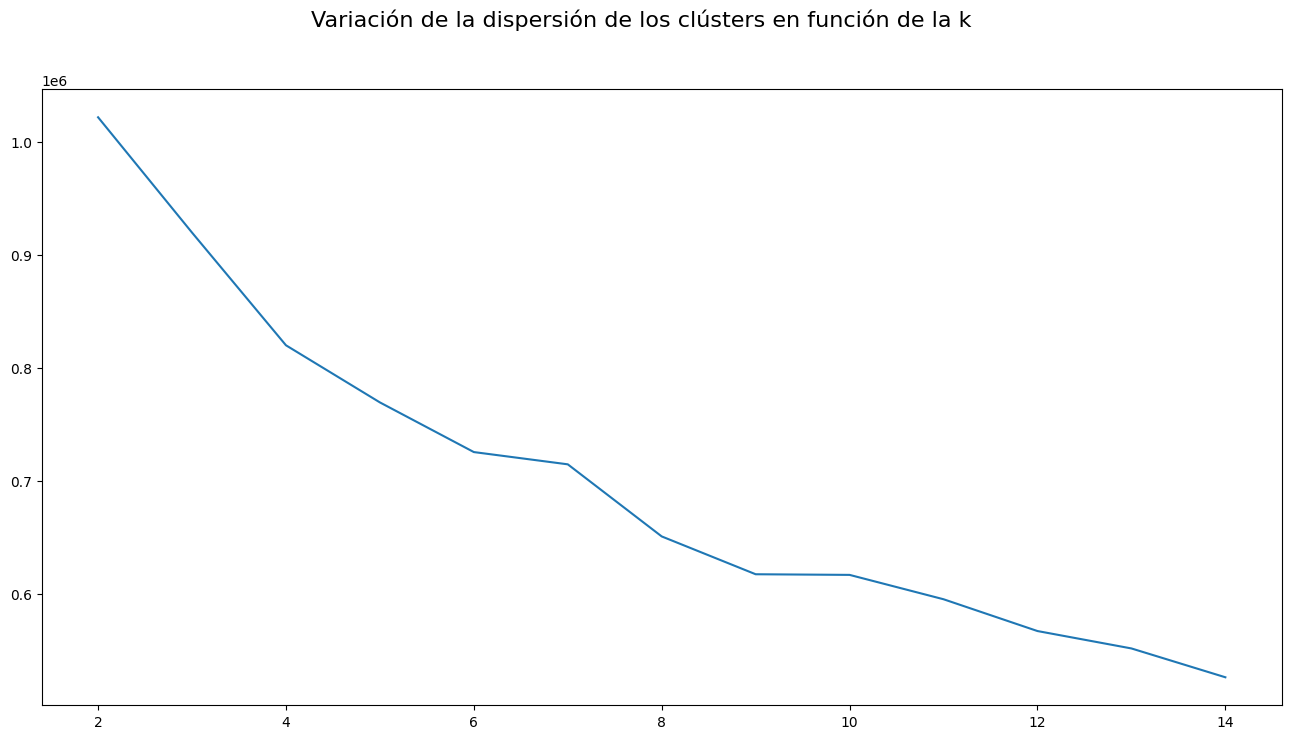

In [85]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot()

x_values = list(sse.keys())
y_values = list(sse.values())

ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")
fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize = 16);

El codo aparece en el 3, donde está el cambio más abrupto. En el 5 y en el 8 hay otra inflexion pero es muy leve, pero el cambio más grande es el 3.


### 4.6 Segmentación de clientes con el K definido

#### Filtramos el pipe con la K adecuada =3

Definimos el nuevo pipe con los mismos parámetros y añadimos el clustering con la K adecuada =3. Ponemos random_state para que se puedan replicar los datos cada vez que se ejecute.

In [86]:
pipe = Pipeline(steps = [
    ("Imputer", KNNImputer()),
    #("CustomTransformer", ClientIdFeatureGenerator), No queremos que nos transforme los datos ni que los escale, ya que la descripción del cluster estará alterada.
    #("RobustScaler", RobustScaler(quantile_range = (0, 99.0))),
    ("Clustering", KMeans(n_clusters = 3, random_state = 175)) # Definir clusters con el num de centroides
])

In [87]:
df_final.shape

(442746, 39)

Tenemos 442748 clientes.

#### Hacemos un fit con el dataset final para aplicar las trasnformaciones correctas definidas en la pipe sobre el df

In [88]:
pipe.fit(df_final)

Pipeline(steps=[('Imputer', KNNImputer()),
                ('Clustering', KMeans(n_clusters=3, random_state=175))])

Hacemos el transform con el df final hasta el 2, por ejemplo

In [89]:
X_processed = pipe[:1].transform(df_final)

In [90]:
X_processed = pd.DataFrame(X_processed, index=df_final.index)

Hacemos el predict para definir las etiquetas de cadauno de los clusters.

In [91]:
labels = pipe.predict(df_final) # le hacemos las labels sobre el df_final, no sobre el escalado, ya que sino será dificil de interpretar etiquetas

In [92]:
# le asignamos el clúster al DataFrame procesado 
X_processed["cluster"] = labels

Juntamos las labels con el dataset

In [93]:
X_processed.shape

(442746, 40)

## 5. Ficha de los clientes

Tenemos que resumir la info para describir los clusters.
Generamos el df ficha_df

In [94]:
ficha_df = pd.DataFrame()

Comparamos el dataset transformado y el final:

In [95]:
X_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 442746 entries, 657826 to 1550586
Data columns (total 40 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   active_customer             442746 non-null  float64
 1   region_code                 442746 non-null  float64
 2   age                         442746 non-null  float64
 3   salary                      442746 non-null  float64
 4   short_term_deposit          442746 non-null  float64
 5   loans                       442746 non-null  float64
 6   mortgage                    442746 non-null  float64
 7   funds                       442746 non-null  float64
 8   securities                  442746 non-null  float64
 9   long_term_deposit           442746 non-null  float64
 10  em_account_pp               442746 non-null  float64
 11  credit_card                 442746 non-null  float64
 12  payroll                     442746 non-null  float64
 13  pension_plan 

In [96]:
X_processed.head()

,active_customer,region_code,age,salary,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,...,entry_channel_Not defined,entry_channel_Others,entry_channel_RED,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Not defined,gender_H,gender_V,cluster
657826,1.0,25.0,44.0,54493.38,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
657817,0.0,8.0,32.0,-1.00,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1
657986,1.0,41.0,39.0,100993.17,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2
657905,1.0,28.0,85.0,154059.09,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1
657336,1.0,28.0,38.0,-1.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1


In [97]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 442746 entries, 657826 to 1550586
Data columns (total 39 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   active_customer             442746 non-null  int32  
 1   region_code                 442746 non-null  int32  
 2   age                         442746 non-null  int64  
 3   salary                      442746 non-null  float64
 4   short_term_deposit          442746 non-null  int64  
 5   loans                       442746 non-null  int64  
 6   mortgage                    442746 non-null  int64  
 7   funds                       442746 non-null  int64  
 8   securities                  442746 non-null  int64  
 9   long_term_deposit           442746 non-null  int64  
 10  em_account_pp               442746 non-null  int64  
 11  credit_card                 442746 non-null  int64  
 12  payroll                     442746 non-null  float64
 13  pension_plan 

In [98]:
df_final

,active_customer,region_code,age,salary,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,...,entry_channel_KHQ,entry_channel_Not defined,entry_channel_Others,entry_channel_RED,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Not defined,gender_H,gender_V
657826,1,25,44,54493.38,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
657817,0,8,32,-1.00,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
657986,1,41,39,100993.17,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
657905,1,28,85,154059.09,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
657336,1,28,38,-1.00,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166765,0,50,22,43912.17,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1166764,0,26,23,23334.99,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1166763,1,50,47,-1.00,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1166789,0,50,22,199592.82,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


Hacemos el resumen con el cluster al que añadimos las columnas mencionadas en el enumerate, que se añade al df de ficha final con el concat

In [99]:
for i, col in enumerate(["active_customer", "age", "salary", "total_products","entry_channel_KAT", "entry_channel_KFA", "entry_channel_KFC","entry_channel_KHE","entry_channel_KHK","entry_channel_KHM","entry_channel_KHN","entry_channel_KHQ","entry_channel_Others","entry_channel_RED","segment_01 - TOP","segment_02 - PARTICULARES","segment_03 - UNIVERSITARIO","segment_Not defined", 'population']): # Meter en la lista las columnas que creamos que nos describen al cliente para ver sobre los clusters en que varian y poder describirlos.
    # ['active_customer', 'entry_channel', 'total_products', ....]
    resumen_data = X_processed[["cluster", col]].groupby("cluster").describe().T[1:]
    ficha_df = pd.concat([ficha_df, resumen_data])

In [100]:
ficha_df

cluster                                     0             1             2
active_customer            mean  4.017393e-01  4.045955e-01  3.297311e-01
                           std   4.902509e-01  4.908154e-01  4.701179e-01
                           min   0.000000e+00  0.000000e+00  0.000000e+00
                           25%   0.000000e+00  0.000000e+00  0.000000e+00
                           50%   0.000000e+00  0.000000e+00  0.000000e+00
                           75%   1.000000e+00  1.000000e+00  1.000000e+00
                           max   1.000000e+00  1.000000e+00  1.000000e+00
age                        mean  2.946040e+01  3.214518e+01  2.985370e+01
                           std   1.149568e+01  1.349483e+01  1.151980e+01
                           min   2.000000e+00  2.000000e+00  2.000000e+00
                           25%   2.200000e+01  2.300000e+01  2.200000e+01
                           50%   2.400000e+01  2.700000e+01  2.500000e+01
                           75%   3.300000e+01  3.900000e+01  3.400000e+01
                           max   1.050000e+02  1.040000e+02  1.020000e+02
salary                     mean  5.943549e+04  1.139789e+05  6.206052e+04
                           std   9.398346e+04  2.697252e+05  1.335066e+05
                           min  -1.000000e+00 -1.000000e+00 -1.000000e+00
                           25%  -1.000000e+00 -1.000000e+00 -1.000000e+00
                           50%   5.388542e+04  8.899709e+04  5.289138e+04
                           75%   9.054916e+04  1.536800e+05  8.690400e+04
                           max   1.571172e+07  2.889440e+07  1.326862e+07
total_products             mean  1.006443e+00  9.425450e-01  1.024354e+00
                           std   7.942794e-01  1.081084e+00  8.292794e-01
                           min   0.000000e+00  0.000000e+00  0.000000e+00
                           25%   1.000000e+00  0.000000e+00  1.000000e+00
                           50%   1.000000e+00  1.000000e+00  1.000000e+00
                           75%   1.000000e+00  1.000000e+00  1.000000e+00
                           max   8.000000e+00  9.000000e+00  8.000000e+00
entry_channel_KAT          mean  5.006967e-02  7.675256e-02  5.307708e-02
                           std   2.180893e-01  2.661994e-01  2.241884e-01
                           min   0.000000e+00  0.000000e+00  0.000000e+00
                           25%   0.000000e+00  0.000000e+00  0.000000e+00
                           50%   0.000000e+00  0.000000e+00  0.000000e+00
                           75%   0.000000e+00  0.000000e+00  0.000000e+00
                           max   1.000000e+00  1.000000e+00  1.000000e+00
entry_channel_KFA          mean  2.075626e-03  3.097650e-02  1.953371e-03
                           std   4.551184e-02  1.732546e-01  4.415400e-02
                           min   0.000000e+00  0.000000e+00  0.000000e+00
                           25%   0.000000e+00  0.000000e+00  0.000000e+00
                           50%   0.000000e+00  0.000000e+00  0.000000e+00
                           75%   0.000000e+00  0.000000e+00  0.000000e+00
                           max   1.000000e+00  1.000000e+00  1.000000e+00
entry_channel_KFC          mean  1.152309e-01  1.662243e-01  1.233039e-01
                           std   3.193011e-01  3.722832e-01  3.287875e-01
                           min   0.000000e+00  0.000000e+00  0.000000e+00
                           25%   0.000000e+00  0.000000e+00  0.000000e+00
                           50%   0.000000e+00  0.000000e+00  0.000000e+00
                           75%   0.000000e+00  0.000000e+00  0.000000e+00
                           max   1.000000e+00  1.000000e+00  1.000000e+00
entry_channel_KHE          mean  4.807092e-01  3.559571e-01  4.729994e-01
                           std   4.996289e-01  4.788040e-01  4.992731e-01
                           min   0.000000e+00  0.000000e+00  0.000000e+00
                           25%   0.000000e+00  0.000000e+00  0.000000e+00
    

Aqui podemos analizar los datos estadísticos para los distintos parámetros de cada clúster. Posteriormente, renombraremos los clusters según sus catacterísticas.

In [101]:
ficha_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 133 entries, ('active_customer', 'mean') to ('population', 'max')
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       133 non-null    float64
 1   1       133 non-null    float64
 2   2       133 non-null    float64
dtypes: float64(3)
memory usage: 4.5+ KB


In [102]:
tamaño_clusters = X_processed.groupby("cluster").size().to_frame().T

In [103]:
ficha_df = pd.concat([tamaño_clusters, ficha_df])

#### Descripción de clusters:

Grupo 0 (cliente con potencial): grupo activo, 29 años, ingresos medios, canales  (KHE), más universitarios, ciudades más pequeñas
Grupo 1 (clientes con curiosidad financiera): grupo activo, 32 años, mayores ingresos, más susceptible a captación por canales (KAT, KFA, KFC), segment TOP y pocos universitarios, ciudades más habitadas
Grupo 2 (tarifa básica): grupo poco activo, 29 años, ingresos medios, menos susceptible a captación por canales (KHE), ningun segment TOP pero si universitarios

In [104]:
ficha_df.style.background_gradient(cmap = 'Blues', axis = 1)

cluster,0,1,2
0,208130.000000,139396.000000,95220.000000
"('active_customer', 'mean')",0.401739,0.404596,0.329731
"('active_customer', 'std')",0.490251,0.490815,0.470118
"('active_customer', 'min')",0.000000,0.000000,0.000000
"('active_customer', '25%')",0.000000,0.000000,0.000000
"('active_customer', '50%')",0.000000,0.000000,0.000000
"('active_customer', '75%')",1.000000,1.000000,1.000000
"('active_customer', 'max')",1.000000,1.000000,1.000000
"('age', 'mean')",29.460405,32.145176,29.853697
"('age', 'std')",11.495679,13.494827,11.519803


Renombramos los clusters de clientes según  sus características.

In [105]:
ficha_df = ficha_df.rename(columns = {
    0 : "Clientes con potencial",
    1 : "Clientes con curiosidad financiera",
    2 : "Clientes tarifa básica",
 })

In [106]:
ficha_df

cluster,Clientes con potencial,Clientes con curiosidad financiera,Clientes tarifa básica
0,2.081300e+05,1.393960e+05,9.522000e+04
"(active_customer, mean)",4.017393e-01,4.045955e-01,3.297311e-01
"(active_customer, std)",4.902509e-01,4.908154e-01,4.701179e-01
"(active_customer, min)",0.000000e+00,0.000000e+00,0.000000e+00
"(active_customer, 25%)",0.000000e+00,0.000000e+00,0.000000e+00
"(active_customer, 50%)",0.000000e+00,0.000000e+00,0.000000e+00
"(active_customer, 75%)",1.000000e+00,1.000000e+00,1.000000e+00
"(active_customer, max)",1.000000e+00,1.000000e+00,1.000000e+00
"(age, mean)",2.946040e+01,3.214518e+01,2.985370e+01
"(age, std)",1.149568e+01,1.349483e+01,1.151980e+01


## 6. Determinación del cluster al que pertenecen nuestros potenciales clientes del modelo supervisado

A partir del modelo de propensión a compra para la tarjeta de crédito se ha generado un ranking de clientes con aquellos que presentan una probabilidad de compra superior al 65%. A continuación, queremos saber a que grupo de clientes pertenecen para conocer sus características y enfocar la campaña de marketing. 

Generamos el dataframe de clients_clustering que contiene, para cada pk_cid, su clasificación en cluster (cliente con potencial, con curiosidad financiera o con tarifa básica).

In [107]:
clients_clustering = X_processed.copy()

Cargamos el csv del ranking de probabilidad de compra de tarjeta de crédito.

In [108]:
# Obtener el directorio de trabajo actual
current_dir = os.getcwd()

# Ir a la carpeta anterior del directorio actual porque ahí se encuentra la carpeta 'data' donde están todos los ficheros .csv
parent_dir = os.path.dirname(current_dir)

DATA_PATH = os.path.join(parent_dir, 'data/') # Ruta donde están los ficheros .csv

FILE_NAME5 = 'df_ranking_credit_card.csv'
FILE5 = os.path.join(DATA_PATH, FILE_NAME5)


print('current path:', current_dir)
print('parent path:', parent_dir)
print('data path:', DATA_PATH)
print('file 5:', FILE5)

print('data path:', DATA_PATH)

current path: c:\Users\odoto\Documents\Nuclio\TFM-EasyMoney\clustering
parent path: c:\Users\odoto\Documents\Nuclio\TFM-EasyMoney
data path: c:\Users\odoto\Documents\Nuclio\TFM-EasyMoney\data/
file 5: c:\Users\odoto\Documents\Nuclio\TFM-EasyMoney\data/df_ranking_credit_card.csv
data path: c:\Users\odoto\Documents\Nuclio\TFM-EasyMoney\data/


In [109]:
df_ranking_credit_card = pd.read_csv(FILE5, index_col=0)

In [110]:
df_ranking_credit_card

""
0
1009904
1234309
270595
1068436
1017614
...
1490878
1497443
1367016


Mergeamos el dataframe del ranking con el dataframe de los clientes con cluster. El merge va a ser inner por el índice que coincide con los pk_cid en ambos casos.

In [111]:
df_ranking_credit_card_clustered = pd.merge(
    left = df_ranking_credit_card, 
    right = clients_clustering,
    left_index = True,
    right_index = True,
    how = 'inner')

In [112]:
df_ranking_credit_card_clustered.shape

(77684, 40)

Tenemos 77684 clientes porpensos a compra y clusterizados.

Podemos conocer que proporcion de cada cluster hay para ese grupo. Además, lo compararemos con el dataset completo de clientes para ver como varía esa proporción de nuestros clientes propensos a compra con respecto al total de clientes.

In [113]:
X_processed['cluster'].value_counts(normalize=True)

cluster
0    0.470089
1    0.314844
2    0.215067
Name: proportion, dtype: float64

In [114]:
df_ranking_credit_card_clustered['cluster'].value_counts(normalize=True)

cluster
1    0.426999
0    0.386412
2    0.186589
Name: proportion, dtype: float64

Podemos ver como la cantidad de clientes propensos a compra conforman una proporcion bastante diferencial de los clientes totales. Con esto, podemos ver que el modelo donde se ha creado el ranking ha funcionado en la distinción.

#### Queremos conocer la edad media de nuestros clientes del cluster:

In [115]:
df_ranking_credit_card_clustered.groupby('cluster')['age'].mean()

cluster
0    44.271404
1    45.726388
2    43.810348
Name: age, dtype: float64

#### Queremos conocer el salario medio de nuestros clientes del cluster:

In [116]:
df_ranking_credit_card_clustered.groupby('cluster')['salary'].mean()

cluster
0     55202.387063
1    104172.126441
2     59196.722634
Name: salary, dtype: float64

Vemos que los clientes que mas probabilidad de compra tienen para la tarjeta de crédito, considerados en el ranking, pertenecen principalmente al cluster de clientes con curiosidad financiera, con un 42%.

Revisamos si en el proceso se han generado duplicados. El resultado es nulo, por lo tanto, no tenemos replicas de pk_cid.

In [117]:
# Filtrar y mostrar las filas donde el índice está duplicado
filas_duplicadas = df_ranking_credit_card[df_ranking_credit_card.index.duplicated(keep=False)]
print(len(filas_duplicadas))

0


In [118]:
hay_duplicados = clients_clustering.index.duplicated().any()

if hay_duplicados:
    print("El DataFrame tiene índices duplicados.")
else:
    print("El DataFrame no tiene índices duplicados.")

# Crear un nuevo DataFrame con las filas que tienen índices duplicados
df_duplicados = clients_clustering[clients_clustering.index.duplicated(keep=False)]

# Mostrar el DataFrame con índices duplicados
print(df_duplicados)

El DataFrame no tiene índices duplicados.
Empty DataFrame
Columns: [active_customer, region_code, age, salary, short_term_deposit, loans, mortgage, funds, securities, long_term_deposit, em_account_pp, credit_card, payroll, pension_plan, payroll_account, emc_account, debit_card, em_account_p, em_acount, total_products, population, entry_channel_KAT, entry_channel_KFA, entry_channel_KFC, entry_channel_KHD, entry_channel_KHE, entry_channel_KHK, entry_channel_KHM, entry_channel_KHN, entry_channel_KHQ, entry_channel_Not defined, entry_channel_Others, entry_channel_RED, segment_01 - TOP, segment_02 - PARTICULARES, segment_03 - UNIVERSITARIO, segment_Not defined, gender_H, gender_V, cluster]
Index: []

[0 rows x 40 columns]


In [120]:
df_ranking_credit_card_clustered.to_csv(DATA_PATH + 'df_ranking_credit_card_clustered.csv', index=False)